# GPT from Scratch: A Step-by-Step Implementation

This notebook provides a clear and organized implementation of a simplified GPT (Generative Pre-trained Transformer) model from scratch using PyTorch. The goal is to understand the core components and mechanisms behind transformer-based language models by building one in a modular and educational manner.

## Overview

1. **Data Preparation**
   - Load raw text data from an online source.
   - Implement a simple tokenizer to convert text into tokens with special tokens for unknown words, beginning/end of sequence, and padding.
   - Create a custom data loader to generate training batches with sliding windows over token sequences.

2. **Core Components**
   - Define token embeddings and positional embeddings to represent input tokens in vector space.
   - Implement masked multi-head self-attention to allow the model to attend to previous tokens only (causal masking).
   - Build essential building blocks such as Layer Normalization, GELU activation, and Feedforward networks.

3. **Transformer Block**
   - Combine multi-head attention and feedforward layers with residual connections and dropout for regularization.
   - Stack these components to form a single transformer block.

4. **GPT Model Architecture**
   - Assemble embedding layers, transformer block, normalization, and output projection into a complete GPT model.
   - The model predicts the next token in a sequence, enabling language modeling and text generation.

## Configuration

- Context window size: 10 tokens
- Embedding dimension: 300
- Batch size: 8
- Stride for sliding window: 3
- Number of attention heads: 10
- Number of Layers: 12
- Dropout rate: 0.1
- learning rate: 5e-5

## Purpose

This notebook aims to demystify the inner workings of GPT models by implementing each component from the ground up. It serves as an educational resource for understanding transformer architectures, attention mechanisms, and language modeling techniques without relying on high-level libraries or pretrained models.

# Load dependencies

In [ ]:
import requests
import re
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
cfg = {
    "context_size": 10,
    "vector_dimension": 300,
    "batch_size": 8,
    "stride": 3,
    "n_heads": 10,
    "n_layer": 12,
    "drop_rate": 0.1,
    "learning_rate": 5e-5
}

# 1. Data Preparation

## 1.1. Load the data

In [ ]:
# URL of the plain text file
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

In [ ]:
response = requests.get(url)
text = response.text
text = text.lstrip('\ufeff')   # This will remove the Byte Order Mark (BOM) as "\ufeff"

print("The number of characters:",len(text))
print(text[:500])

The number of characters: 20479
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no great surprise to me to hear that, in the height of his glory, he had dropped his painting, married a rich widow, and established himself in a villa on the Riviera. (Though I rather thought it would have been Rome or Florence.)

"The height of his glory"--that was what the women called it. I can hear Mrs. Gideon Thwing--his last Chicago sitter--deploring his unaccountable abdication. "Of course it'


## 1.2. Tokenize the data

In [ ]:
class SimpleTokenizer:
  def __init__(self, text):

    tokens = self.__tokenize(text)
    all_words = sorted(set(tokens))

    # Adding Special Tokens
    # - <UNK> -> Handling out-of-vocabulary words
    # - (BOS) -> Put in begenning of each document
    # - (EOS) -> Put in end of each document
    # - Padding (BAD) -> Handling unequal sentences in length
    all_words.extend(('<UNK>','<BOS>','<EOS>','<PAD>'))

    self.voc_str_int = {word: i for i, word in enumerate(all_words)}
    self.voc_int_str = {i: word for i, word in enumerate(all_words)}

  def __tokenize(self, text):

    tokens = re.split(r'([,.?_!"()\':;]|--|\s)', text)

    tokens = [token.strip() for token in tokens if token.strip()]

    return tokens

  def encode(self, text):

    tokens = self.__tokenize(text)

    ids = [self.voc_str_int.get(token, self.voc_str_int['<UNK>']) for token in tokens]

    return ids

  def decode(self, ids):

    tokens = [self.voc_int_str.get(id, '<UNK>') for id in ids]

    text = ' '.join(tokens)

    text = re.sub(r'\s+([,.?_!"()\':;]|--|\s)', r'\1', text) # Remove spaces before this specified characters (eg. ,.?)

    return text

  def __len__(self):
    return len(self.voc_str_int)


## 1.3. Data Loader

In [ ]:
class SimpleDataLoader:
  def __init__(self, token_ids, context_size=4, batch_size=4, stride=1):
    self.context_size = context_size
    self.batch_size = batch_size
    self.stride = stride

    self.X, self.Y = self.__create_dataset(token_ids)

  def __create_dataset(self, token_ids):
    X, Y = [], []
    for i in range(0, len(token_ids) - self.context_size - 1, self.stride):
      x = token_ids[i : i + self.context_size]
      y = token_ids[i + 1 : i + self.context_size + 1]

      if len(y) == self.context_size:
        X.append(x)
        Y.append(y)

    return torch.tensor(X, dtype=torch.long), torch.tensor(Y, dtype=torch.long)

  def __len__(self):
    return len(self.X) // self.batch_size

  def __getitem__(self, idx):
    if idx >= len(self):
          raise IndexError("Batch index out of range")
    start = idx * self.batch_size
    end = start + self.batch_size
    return self.X[start:end], self.Y[start:end]


## 1.4. Tokenize text and create data loaders

In [ ]:
# Create Tokenizer
tokenizer = SimpleTokenizer(text)
token_ids = tokenizer.encode(text)
cfg['vocabulary_size'] = len(tokenizer)

# split (90% training, 10% validation)
split_ratio = 0.9
split_index = int(len(token_ids) * split_ratio)
train_token_ids = token_ids[:split_index]
val_token_ids = token_ids[split_index:]

# Create Data Loader
train_dataloader = SimpleDataLoader(train_token_ids, cfg["context_size"], cfg["batch_size"], cfg["stride"])
val_dataloader = SimpleDataLoader(val_token_ids, cfg["context_size"], cfg["batch_size"], cfg["stride"])
x_batch, y_batch = train_dataloader[0]

print("Vocabulary size:", len(tokenizer))
print("Number of training batchs:", len(train_dataloader))
print("Number of validation batchs:", len(val_dataloader))
print("X:", x_batch[0])
print("Y:", y_batch[0])

Vocabulary size: 1134
Number of training batchs: 175
Number of validation batchs: 19
X: tensor([  53,   44,  149, 1003,   57,   38,  818,  115,  256,  486])
Y: tensor([  44,  149, 1003,   57,   38,  818,  115,  256,  486,    6])


# 2. Masked multi-head attention by weights splits with query, key, and value matrices

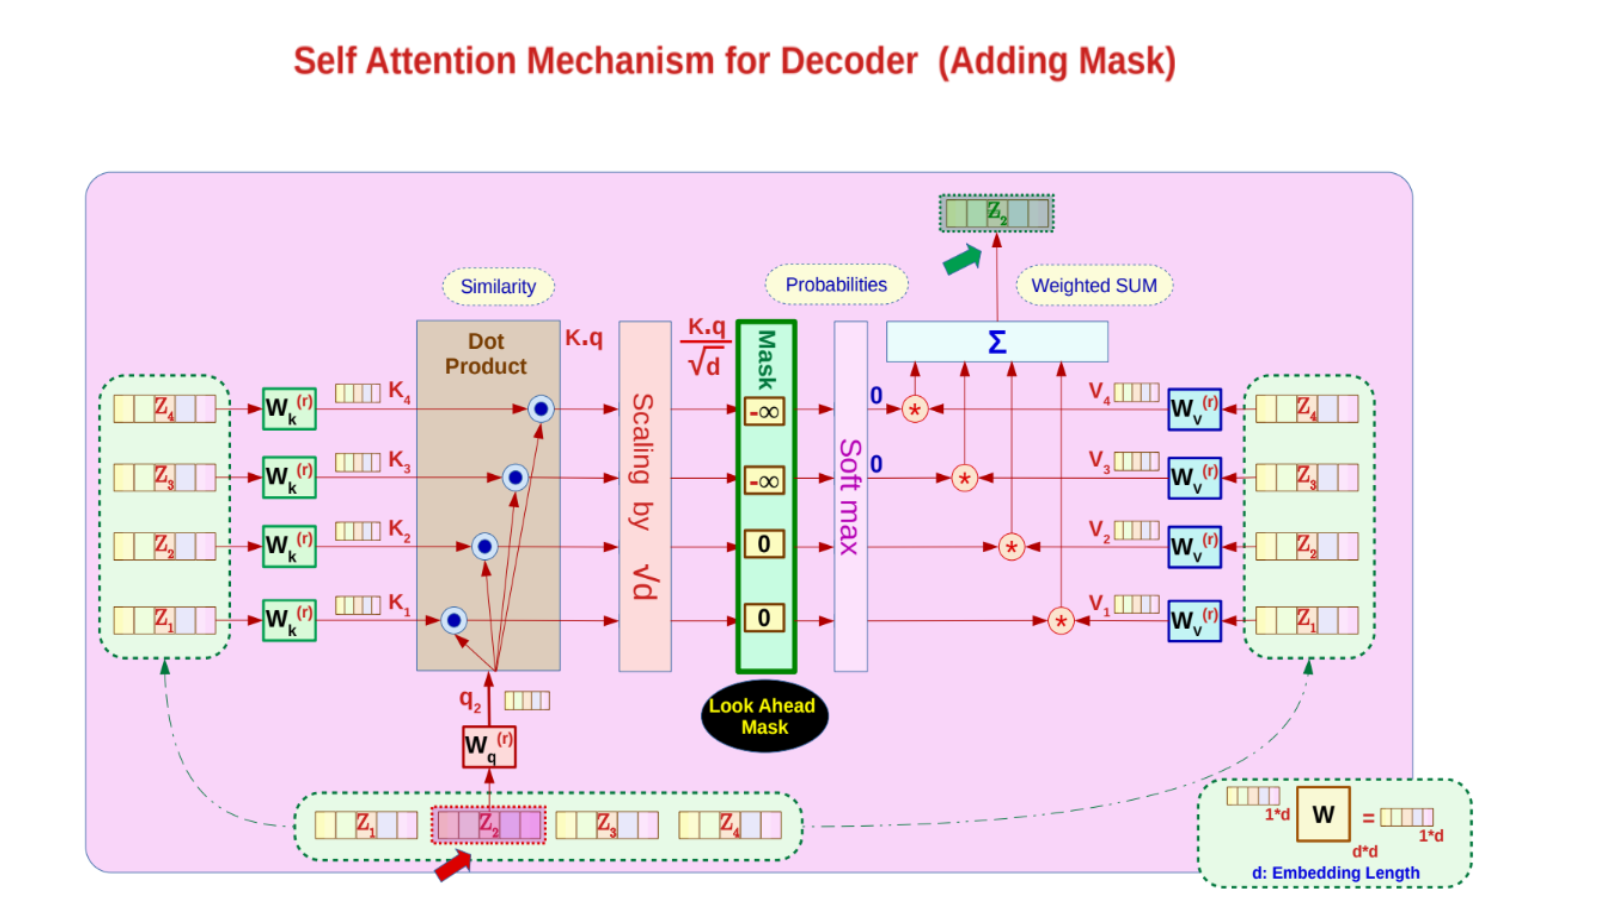

In [ ]:
class MaskedMultiHeadAttention(nn.Module):
    def __init__(self, vector_dim, output_dim, num_heads):
        super(MaskedMultiHeadAttention, self).__init__()

        self.vector_dim = vector_dim    # Dimension of input embeddings
        self.output_dim = output_dim    # Dimension of Q, K, V, and final output
        self.num_heads = num_heads
        self.head_dim = output_dim // num_heads  # Dimension per head

        # Linear projections
        self.query = nn.Linear(vector_dim, output_dim, bias=False)
        self.key   = nn.Linear(vector_dim, output_dim, bias=False)
        self.value = nn.Linear(vector_dim, output_dim, bias=False)

        # Final output projection
        self.out_proj = nn.Linear(output_dim, output_dim)

        # Causal mask: upper-triangular matrix filled with -inf (except diagonal and below)
        self.register_buffer("causal_mask", torch.tril(torch.ones(1000, 1000)).unsqueeze(0).unsqueeze(0))  # (1, 1, max_context, max_context)

    def forward(self, x):
        Batch, context_size, _ = x.shape  # (Batch, context_size, vector_dim)

        # Linear projections: (Batch, context_size, vector_dim) * (vector_dim, output_dim) = (Batch, context_size, output_dim)
        Queries = self.query(x)
        Keys    = self.key(x)
        Values  = self.value(x)

        # Reshape: (Batch, context_size, output_dim) → (Batch, context_size, num_heads, head_dim)
        Queries = Queries.view(Batch, context_size, self.num_heads, self.head_dim)
        Keys    = Keys.view(Batch, context_size, self.num_heads, self.head_dim)
        Values  = Values.view(Batch, context_size, self.num_heads, self.head_dim)

        # Transpose to (Batch, num_heads, context_size, head_dim)
        Queries = Queries.transpose(1, 2)
        Keys    = Keys.transpose(1, 2)
        Values  = Values.transpose(1, 2)

        # Compute attention scores: (Batch, num_heads, context_size, head_dim) * (Batch, num_heads, head_dim, context_size) = (Batch, num_heads, context_size, context_size)
        AttentionScores = torch.matmul(Queries, Keys.transpose(-2, -1))

        # Apply causal mask: (Batch, num_heads, context_size, context_size)
        mask = self.causal_mask[:, :, :context_size, :context_size]  # crop mask to match context_size
        AttentionScores = AttentionScores.masked_fill(mask == 0, float('-inf'))

        # Scale and apply softmax
        AttentionWeights = F.softmax(AttentionScores / (self.head_dim ** 0.5), dim=-1)

        # Weighted sum: (Batch, num_heads, context_size, context_size) * (Batch, num_heads, context_size, head_dim) = (Batch, num_heads, context_size, head_dim)
        Context = torch.matmul(AttentionWeights, Values)

        # Transpose back: (Batch, context_size, num_heads, head_dim)
        Context = Context.transpose(1, 2)

        # Concatenate heads: (Batch, context_size, num_heads * head_dim) = (Batch, context_size, output_dim)
        Context = Context.contiguous().view(Batch, context_size, self.output_dim)

        # Final output projection
        Output = self.out_proj(Context)  # (Batch, context_size, output_dim)

        return Output


# 3. GPT Block

## 3.1. Layer Normalization

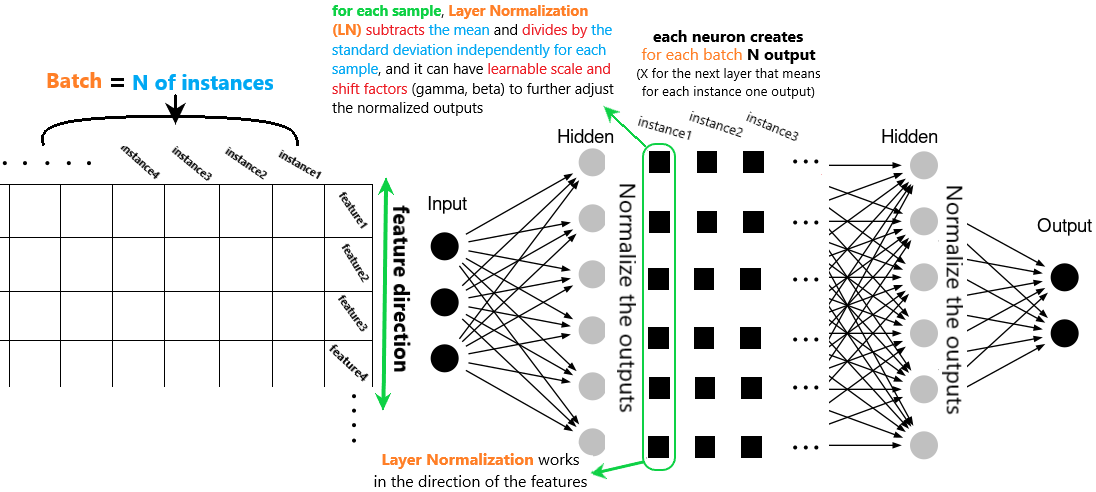

In [ ]:
class LayerNorm(nn.Module):
  def __init__(self, vector_dim):
    super().__init__()
    self.eps = 1e-5
    self.scale = nn.Parameter(torch.ones(vector_dim))
    self.shift = nn.Parameter(torch.zeros(vector_dim))

  def forward(self, x):
    mean = x.mean(dim = -1, keepdim = True)
    std = x.std(dim=-1, keepdim=True, unbiased=False)
    norm_x = (x - mean) / (std + self.eps)

    return self.scale * norm_x + self.shift # This allows the model to learn appropriate scaling and shifting that best suit the data

## 3.2. Gelu activation function

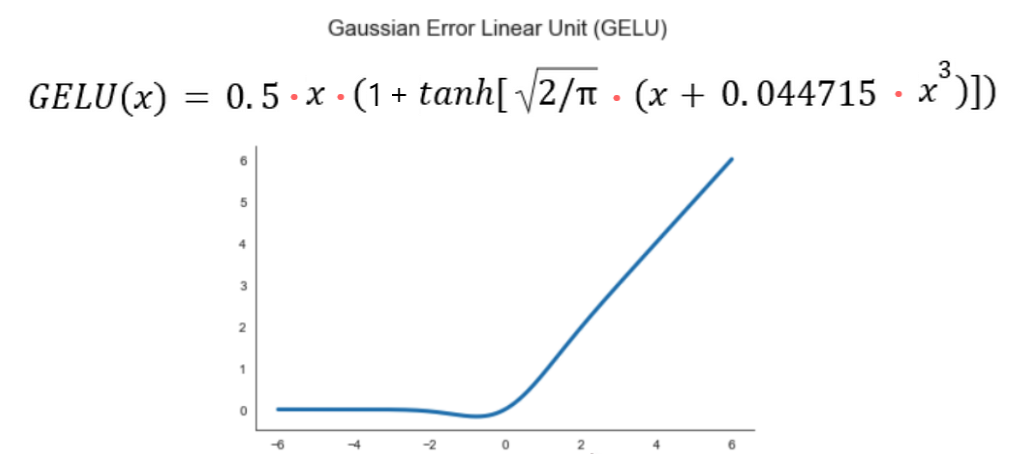

In [ ]:
class Gelu(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x):
    return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2 / torch.pi)) *
             (x + 0.044715 * torch.pow(x, 3))
             )
          )

## 3.3. Feedforward network

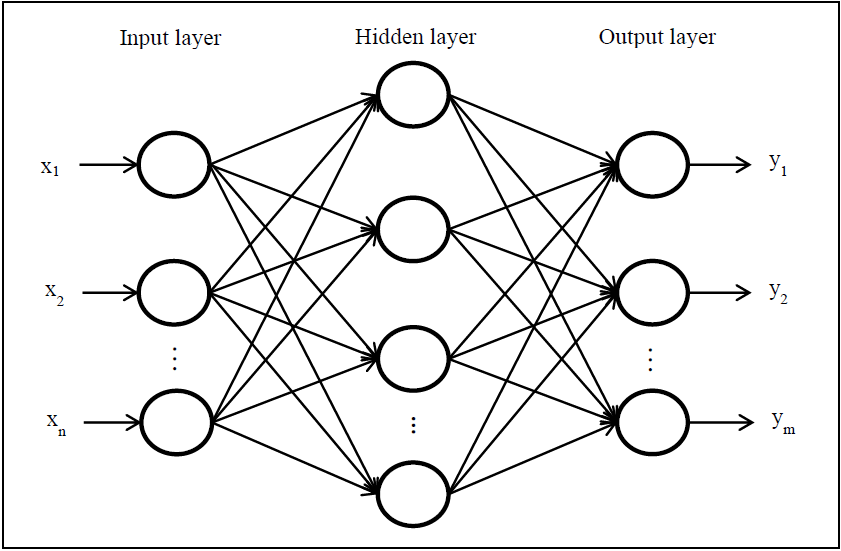

In [ ]:
class FeedForward(nn.Module):
  def __init__(self, vector_dim):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(vector_dim, 4 * vector_dim),
        Gelu(),
        nn.Linear(4 * vector_dim, vector_dim),
    )

  def forward(self, x):
    return self.net(x)

## 3.4. Transformer architecture

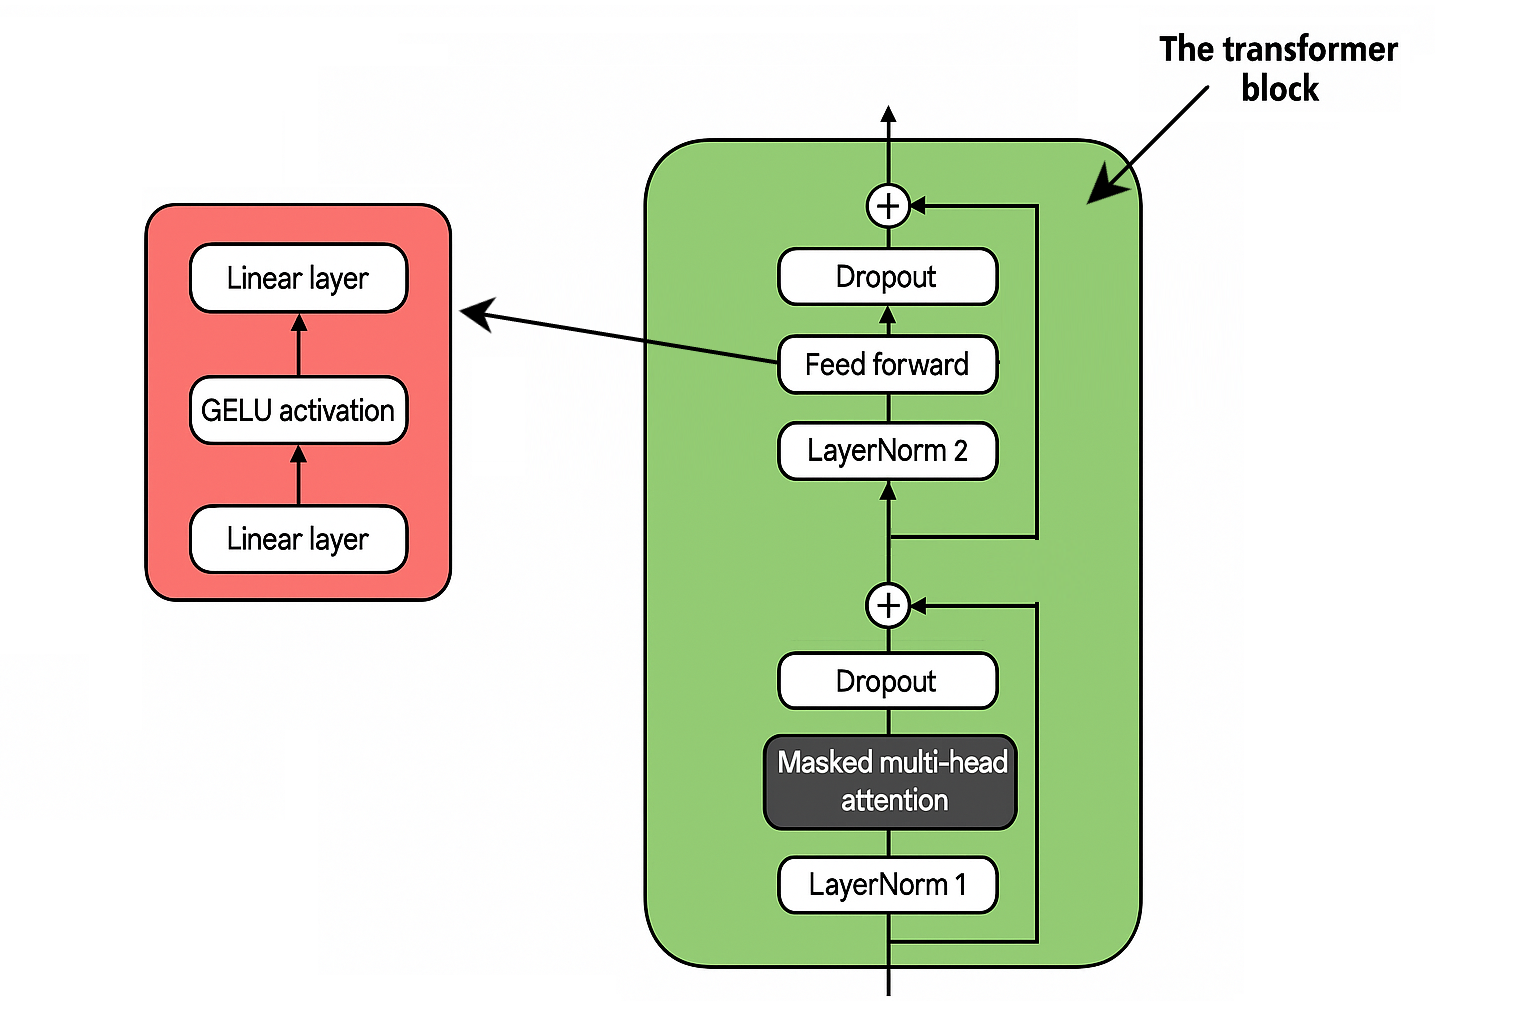


In [ ]:
class TransformerBlock(nn.Module):
  def __init__(self, cfg):
    super(TransformerBlock, self).__init__()

    # Attention block
    self.Normlayer1 = LayerNorm(cfg["vector_dimension"])  # First norm layer
    # Masked multi-head attenstion
    self.multihead_att = MaskedMultiHeadAttention(cfg["vector_dimension"], cfg["vector_dimension"], cfg["n_heads"])
    self.dropout1 = nn.Dropout(cfg["drop_rate"])  # First dropout layer

    # feedforward block
    self.Normlayer2 = LayerNorm(cfg["vector_dimension"])  # Second norm layer
    self.feedforward = FeedForward(cfg["vector_dimension"])  # Feedforward layer
    self.dropout2 = nn.Dropout(cfg["drop_rate"])  # Second dropout layer

  def forward(self, x):  # (batch_size, context_size, vector_dim)

    # Shortcut connection for attention block
    shortcut = x
    x = self.Normlayer1(x)
    x = self.multihead_att(x)
    x = self.dropout1(x)
    x = x + shortcut

    # shortcut connection for feed forward block
    shortcut = x
    x = self.Normlayer2(x)
    x = self.feedforward(x)
    x = self.dropout2(x)
    return x + shortcut   # (batch_size, context_size, vector_dim)

## 3.5. GPT Block

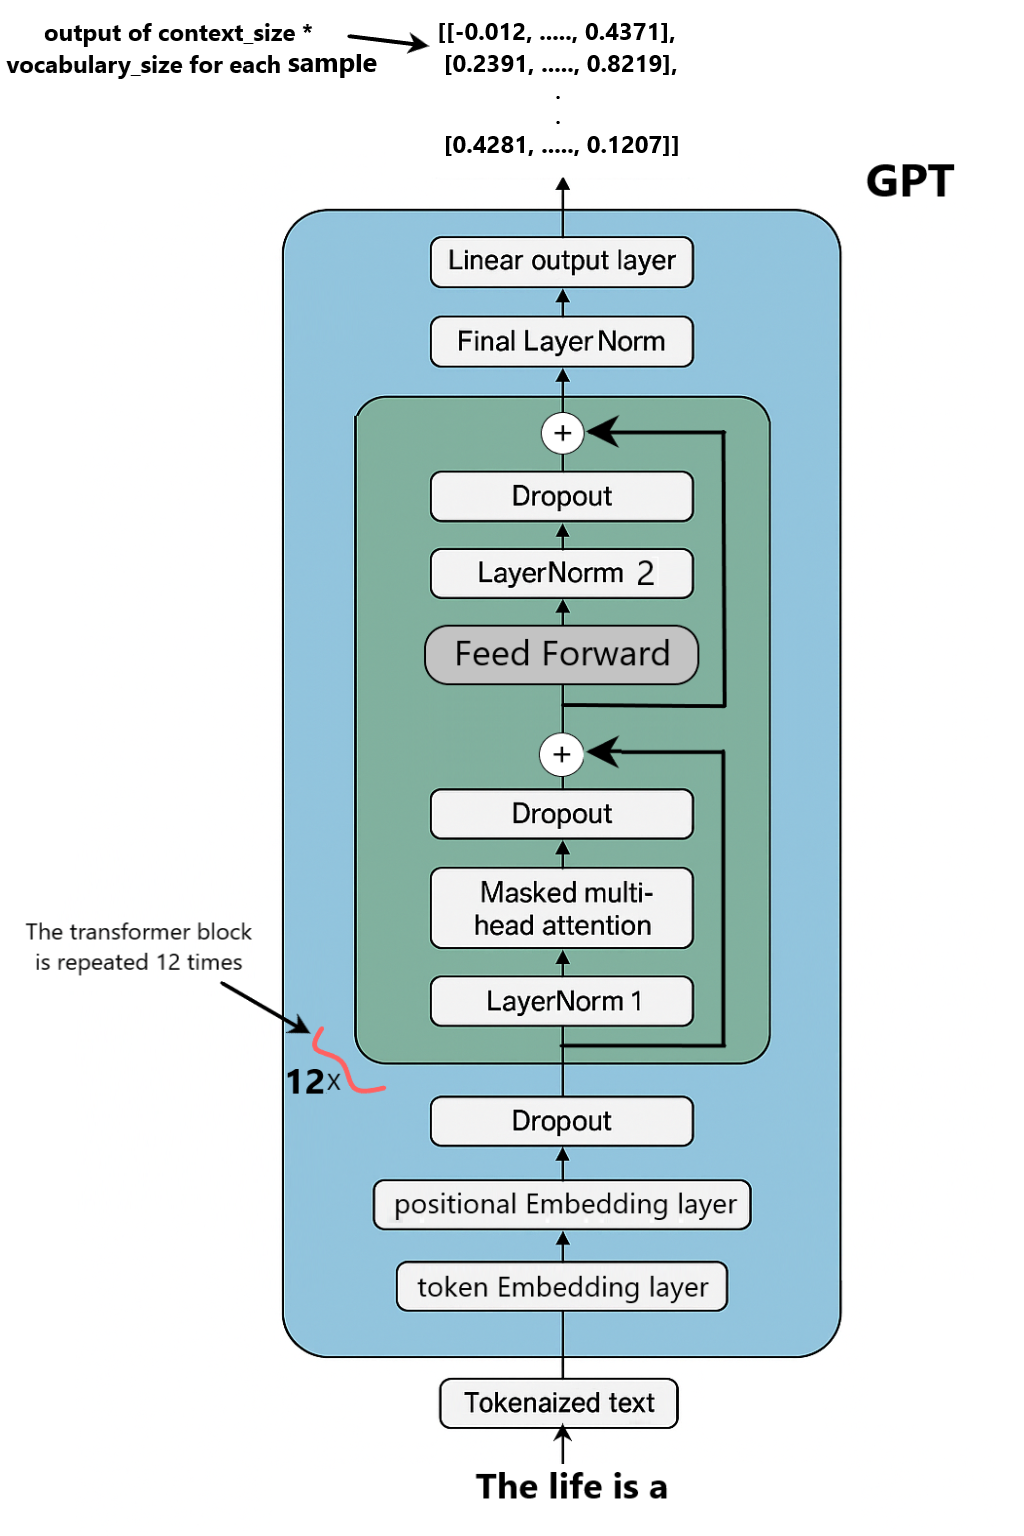

In [ ]:
class GPT(nn.Module):
  def __init__(self, cfg):
    super().__init__()

    self.embedding_layer = nn.Embedding(cfg['vocabulary_size'], cfg["vector_dimension"])  # Embedding layer
    self.position_layer = nn.Embedding(cfg["context_size"], cfg["vector_dimension"])  # Positional Embedding Layer
    self.drop_out = nn.Dropout(cfg["drop_rate"])

    self.transformerblocks = nn.Sequential(
        *[TransformerBlock(cfg) for _ in range(cfg["n_layer"])]  # Use unpacking *[] to pass each module as a separate argument
        )

    self.norm_layer = LayerNorm(cfg["vector_dimension"])
    self.output_layer = nn.Linear(cfg["vector_dimension"], cfg["vocabulary_size"])

  def forward(self, x):
    context_size = x.shape[-1]

    x_embedding = self.embedding_layer(x)  # Get batch Embedding
    x_position = self.position_layer(torch.arange(context_size, device=x.device))  # Generate position indices: shape (context_size,)
    position_encoded_values = x_embedding + x_position  # Add position encoding

    dropped_x = self.drop_out(position_encoded_values)
    x = self.transformerblocks(dropped_x)

    x = self.norm_layer(x)
    logits = self.output_layer(x)

    return logits

In [ ]:
# Create gpt model
gpt_model = GPT(cfg)

# Show number of parameters
num_parameters = sum(p.numel() for p in gpt_model.parameters())
print(f"Number of parameters: {num_parameters:,}")

# Each parameter is usually a 32-bit float (4 bytes)
param_memory_MB = num_parameters * 4 / (1024 ** 2)  # in megabytes
print(f"Model parameter memory: {param_memory_MB:.2f} MB")

Number of parameters: 13,681,134
Model parameter memory: 52.19 MB


# 4. Training GPT model

## 4.1. Cross Entropy Loss

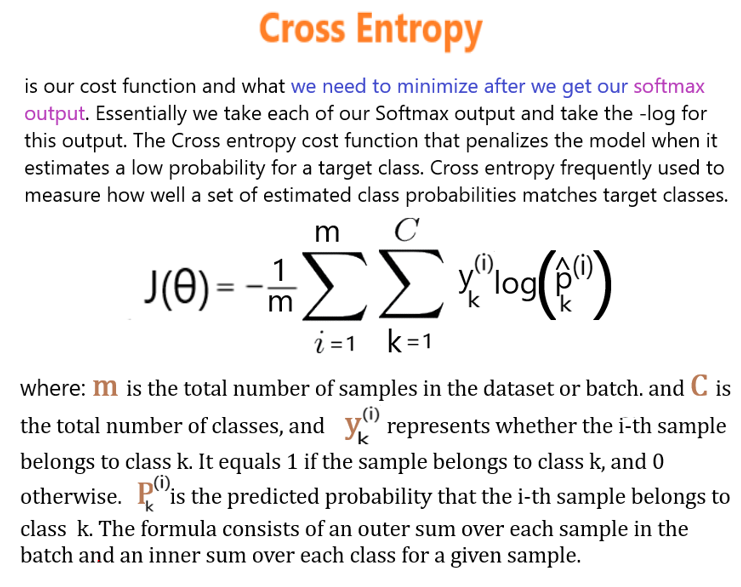

In [ ]:
class MyCrossEntropyLoss(nn.Module):
  def __init__(self):
    super(MyCrossEntropyLoss, self).__init__()

  def forward(self, logits, targets):
    """
    logits: Tensor of shape (N, C) — raw scores from the model
    targets: Tensor of shape (N,) — correct class indices for each example
    """
    # Compute log softmax
    # probs[i][j] = exp(logits[i][j]) / sum_k exp(logits[i][k])
    # log_probs = log(probs[i][j])
    log_probs = F.log_softmax(logits, dim=1)  # shape: (N, C)

    # Select the log-probability of the correct class for each sample
    # target_log_probs[i] = log_probs[i][targets[i]]
    target_log_probs = log_probs[torch.arange(logits.size(0)), targets]  # shape: (N,)

    # Compute the mean negative log-likelihood
    # loss = - (1/N) * sum_i target_log_probs[i]
    loss = -target_log_probs.mean()
    return loss

## 4.2. Training loop

In [ ]:
optimizer = torch.optim.Adam(gpt_model.parameters(), lr=cfg["learning_rate"])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gpt_model.to(device)

epochs = 100
# Instantiate custom loss
criterion = MyCrossEntropyLoss()

for epoch in range(epochs):
    gpt_model.train()  # Set model to training mode
    total_train_loss = 0

    # Assuming train_dataloader provides batches of (input_ids, target_ids)
    for batch_idx, (inputs, targets) in enumerate(train_dataloader):

        # Adding inputs and targets into the device
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()  # Clear previous gradients

        # Forward pass
        logits = gpt_model(inputs)

        # Reshape logits and targets for the custom loss function
        logits = logits.view(-1, logits.size(-1)) # (batch_size * sequence_length, vocab_size)
        targets = targets.view(-1)              # (batch_size * sequence_length,)

        loss = criterion(logits, targets)

        # Backward pass and optimization
        loss.backward()

        # Add gradient clipping
        torch.nn.utils.clip_grad_norm_(gpt_model.parameters(), max_norm=1.0)

        optimizer.step()

        total_train_loss += loss.item()

        if (batch_idx + 1) % 10 == 0: # Print loss every 100 batches
            print(f'Epoch [{epoch+1}/{epochs}], Step [{batch_idx+1}/{len(train_dataloader)}], Loss: {loss.item():.4f}')

    avg_train_loss = total_train_loss / len(train_dataloader)
    print(f'Epoch [{epoch+1}/{epochs}] Training Loss: {avg_train_loss:.4f}')


    # validation loop after each epoch
    gpt_model.eval() # Set model to evaluation mode

    total_val_loss = 0
    with torch.no_grad(): # Disable gradient computation during validation
        for inputs, targets in val_dataloader:
              inputs, targets = inputs.to(device), targets.to(device) # Uncomment if using GPU

              logits = gpt_model(inputs)

              logits = logits.view(-1, logits.size(-1))
              targets = targets.view(-1)

              loss = criterion(logits, targets)
              total_val_loss += loss.item()
    avg_val_loss = total_val_loss / len(val_dataloader)
    print(f'Epoch [{epoch+1}/{epochs}] Validation Loss: {avg_val_loss:.4f}')

print("Training finished.")


Epoch [1/100], Step [10/175], Loss: 6.9740
Epoch [1/100], Step [20/175], Loss: 6.7263
Epoch [1/100], Step [30/175], Loss: 6.5319
Epoch [1/100], Step [40/175], Loss: 6.3264
Epoch [1/100], Step [50/175], Loss: 5.9992
Epoch [1/100], Step [60/175], Loss: 6.2358
Epoch [1/100], Step [70/175], Loss: 6.0184
Epoch [1/100], Step [80/175], Loss: 6.2374
Epoch [1/100], Step [90/175], Loss: 6.1411
Epoch [1/100], Step [100/175], Loss: 6.0887
Epoch [1/100], Step [110/175], Loss: 6.4877
Epoch [1/100], Step [120/175], Loss: 6.0960
Epoch [1/100], Step [130/175], Loss: 5.8936
Epoch [1/100], Step [140/175], Loss: 5.9207
Epoch [1/100], Step [150/175], Loss: 6.0384
Epoch [1/100], Step [160/175], Loss: 6.2373
Epoch [1/100], Step [170/175], Loss: 5.8130
Epoch [1/100] Training Loss: 6.2138
Epoch [1/100] Validation Loss: 5.7965
Epoch [2/100], Step [10/175], Loss: 5.9097
Epoch [2/100], Step [20/175], Loss: 5.4672
Epoch [2/100], Step [30/175], Loss: 5.7958
Epoch [2/100], Step [40/175], Loss: 5.7516
Epoch [2/100], 

# 5. Test model on real input

In [ ]:
def generate_text(model, idx, max_tokens, context_size):

  for _ in range(max_tokens):

    # Take the last context_size tokenx
    idx_window = idx[:, -context_size:]  # (Batch_size, context_size)

    with torch.no_grad():
      logits = model(idx_window)  # (Batch_size, context_size, vocabulary_size)

    # Take the entire batch with entire vecotr for the last token only (-1)
    logits = logits[:, -1, :]    # (Batch_size, vocabulary_size)

    # Apply softmax activation function
    probs = torch.softmax(logits, dim = -1)  # (Batch_size, vocabulary_size)

    # Apply argmax to find the indices
    next_idx = torch.argmax(probs, dim=-1, keepdim=True)  # (Batch_size, 1)

    # Concatenate next index with the indices
    idx = torch.cat((idx, next_idx), dim=1) # (Batch_size, context_size + 1)

  return idx

In [ ]:
Sentence = "I am here to"
tokens = tokenizer.encode(Sentence)

# Convert tokens to tensor and add batch dimension
input_tensor = torch.tensor(tokens, dtype=torch.long).unsqueeze(0).to(device)

gpt_model.eval()

output_tensor = generate_text(
    gpt_model,
    input_tensor,
    6,
    cfg["context_size"]
)

# Print output token indices
print("Output Indices:")
print(output_tensor)

# Convert indices into text
output_text = [tokenizer.decode(seq.tolist()) for seq in output_tensor]

# Print the generated text
print("\nGenerated Text:")
print(output_text)

Output Indices:
tensor([[  53,  150,  540, 1016,  697,  555,    8,    1,   53,  696]],
       device='cuda:0')

Generated Text:
['I am here to my hostess:" I must']
